# Evaluation of the `Hagrad`-Optimizer with Mnist-Dataset

"Hagrad" - **Ha**miltonian **Gr**adient **D**escent, based on Maddison, C. J., Paulin, D., Teh, Y. W., O'Donoghue, B., & Doucet, A. (2018). *Hamiltonia Descent Methods*. [arXiv:1809.05042 [math.OC]](arXiv:1809.05042).

Implementation of custom `tf`/`tf.keras` optimizer inspired by [https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/](https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/)

### Imports and Data

In [1]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## For dev (not having to restart kernel to apply changes in hagrad)
from importlib import reload  # For de Python 3.4+
import hagrad
hagrad = reload(hagrad)

## Hagrad custom optimizer
from hagrad import Hagrad
from hagrad import KineticEnergyGradients

In [2]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape  == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape  == (10000,)

In [3]:
## Class number and sanity check
num_classes = 10
assert np.all(np.sort(np.unique(y_train)) == np.arange(num_classes))

## Normalizing and expanding dimensions for ConvLayers
def perpare_X_data(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32) / 255.
    X = np.expand_dims(X, -1)
    return(X)

X_train = perpare_X_data(X_train)
X_test  = perpare_X_data(X_test)

## convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

### Separation of a validation set

Not nessecairy because we mainly care about the optimizer.

In [4]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.1)
X_valid, y_valid = X_test, y_test

### Defining Model generating function

Using the proposed convnet from the keras-people from https://keras.io/examples/vision/mnist_convnet/.

In [5]:
def generate_model(
    input_shape: tuple,
    num_classes: int,
    opt: keras.optimizers.Optimizer,
    PRINT_SUMMARY: bool=False
) -> keras.Model:
    model = keras.Sequential(
        [
            # layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
            # layers.MaxPooling2D(pool_size=(2, 2)),
            # layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            # layers.MaxPooling2D(pool_size=(2, 2)),
            # layers.Flatten(),

            layers.Flatten(input_shape=input_shape),
            layers.Dense(128),
            # layers.Dropout(0.3),
            layers.Dense(128),
            # layers.Dropout(0.4),
            layers.Dense(128),


            # layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=["accuracy"])

    if PRINT_SUMMARY: print(model.summary())

    return(model)


## Train Models

In [6]:
batch_size  = 128
epochs      = 20
input_shape = X_train.shape[1:]
print(input_shape)

(28, 28, 1)


### Train baseline with SGD and Adam

In [7]:
# keras.backend.clear_session()
# model_adam = generate_model(input_shape=input_shape, num_classes=num_classes, opt=keras.optimizers.Adam(), PRINT_SUMMARY=False)
# fit_adam = model_adam.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

In [8]:
# keras.backend.clear_session()
# model_sgd = generate_model(input_shape=input_shape, num_classes=num_classes, opt=keras.optimizers.SGD(), PRINT_SUMMARY=False)
# fit_sgd = model_sgd.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

In [13]:
keras.backend.clear_session()

power_gradients = KineticEnergyGradients(2., 2.)

custom_hagrad=Hagrad(epsilon=1., gamma=10., kinetic_energy_gradient=KineticEnergyGradients.classical)
# custom_hagrad=Hagrad(epsilon=1., gamma=10., kinetic_energy_gradient=power_gradients.power)
print(custom_hagrad.get_config())

model_hagrad = generate_model(
    input_shape=input_shape, 
    num_classes=num_classes, 
    opt=custom_hagrad, 
    PRINT_SUMMARY=False
)

fit_hagrad = model_hagrad.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

{'name': 'hagrad', 'epsilon': 1.0, 'gamma': 10.0, 'delta': 0.09091, 'kinetic_energy': 'deprecated', 'kinetic_energy_gradient': 'Classical kinetic energy ||p||^2/2 with gradient p.'}
Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 0.4068 - accuracy: 0.8818 - val_loss: 0.3059 - val_accuracy: 0.9106
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3180 - accuracy: 0.9095 - val_loss: 0.3006 - val_accuracy: 0.9137
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3023 - accuracy: 0.9142 - val_loss: 0.3007 - val_accuracy: 0.9121
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2953 - accuracy: 0.9164 - val_loss: 0.3362 - val_accuracy: 0.9027
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2903 - accuracy: 0.9181 - val_loss: 0.3057 - val_accuracy: 0.9105
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2855 - accuracy: 0.9195 - val_lo

## Visualizing

In [11]:
epochs_arr = np.arange(epochs)

## Keras is evaluating the validation error in the end of each epoch. 
#  Therefore these values get shifted for the visualization:
epochs_arr_val = epochs_arr + 0.5



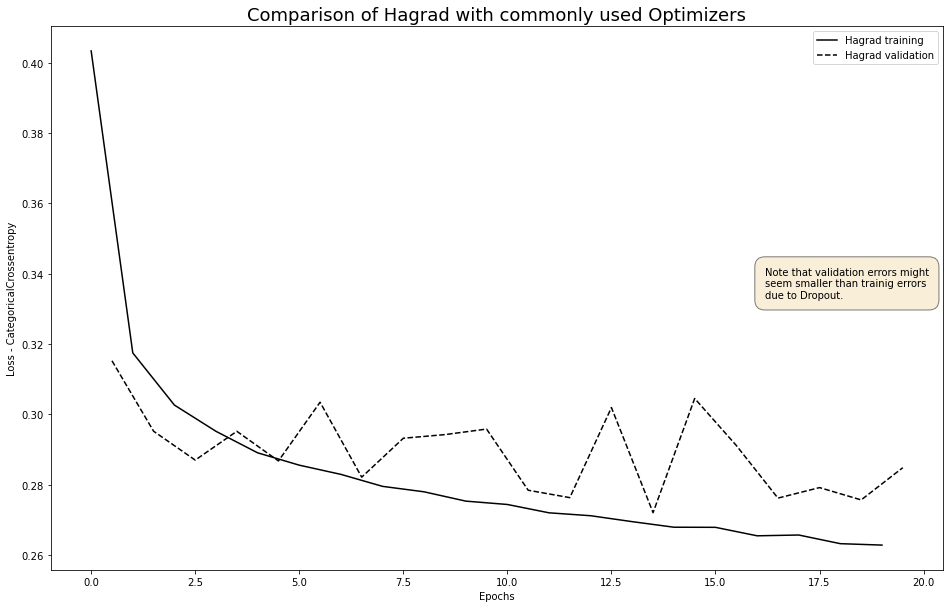

In [12]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Comparison of Hagrad with commonly used Optimizers", fontsize=18)
# ax.plot(epochs_arr, fit_adam.history['loss'], "r-", label="keras.optimizers.Adam training") 
# ax.plot(epochs_arr_val, fit_adam.history['val_loss'], "r--", label="keras.optimizers.Adam validation") 
# plt.plot(epochs_arr, fit_sgd.history['loss'], "g-", label="keras.optimizers.SGD training") 
# plt.plot(epochs_arr_val, fit_sgd.history['val_loss'], "g--", label="keras.optimizers.SGD validation") 
plt.plot(epochs_arr, fit_hagrad.history['loss'], "k-", label="Hagrad training") 
plt.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="Hagrad validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True)
scale_x = ax.get_xlim()[1] - ax.get_xlim()[0]
scale_y = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.text(
    x=ax.get_xlim()[1] - 0.2*scale_x, y=ax.get_ylim()[1] - 0.5*scale_y, 
    s="Note that validation errors might\nseem smaller than trainig errors\ndue to Dropout.", 
    bbox=dict(facecolor='wheat', alpha=0.5, boxstyle='round,pad=1'),
    )
plt.show()